## Functions for loading and plotting SD and DALEC data from multiple days

I've already prototyped some of this in `SD_8-20Aug22.ipynb`. So just gonna generalise into useful functions

In [1]:
# probably won't need all of this stuff, but why not import it all?

import SD_raster_loading
import SD_NC_loading
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dalecLoad
import spectralConv
import os
from datetime import datetime


In [2]:
# now gonna try to look at all SD files:

def load_multiple_SDs(SD_directory, coord, pixel_grid_shape=(1, 1), div_by_pi=True):
    '''
    Loads all L2R netcdfs in a given directory. Then extracts a grid of shape=pixel_grid_shape at the given coord
    Returns a pandas DF with Date, Wavelength, and rho_s columns
    Note that the rho_s columns will be formatted as per `SD_NC_loading.get_SD_NC_Spectra_grid()`
    option div_by_pi will change the units to match the DALEC units
    '''
    # could use list comprehensions in a few places here if things start getting slow!
    SD_files = []
    for file in os.listdir(SD_directory):
        if file.endswith("L2R.nc"):
            SD_files.append(os.path.join(SD_directory, file))


    ncdf_dates = []
    indexes = []
    SD_spect_list = []

    for i in range(len(SD_files)):
        f = netCDF4.Dataset(SD_files[i])
        SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3))
        ncdf_dates.append(f.isodate)
        indexes.append(i)
        SD_spect_list.append(SD_spect)
    
    
    # currently my code which removes images from the same date relies on the images being sorted in date order ...
    SD_spect_list_sorted = [x for _, x in sorted(zip(ncdf_dates, SD_spect_list))]
    sorted_dates = sorted(ncdf_dates)
    
    SD_df = None # this is almost definitely uneccesary
    
    # perhaps have removing images from same date as an option??
    for i in range(len(SD_spect_list_sorted)):
        SD_spect = SD_spect_list_sorted[i]
        date = sorted_dates[i]
        if date[:10] != sorted_dates[i-1][:10]: # can't be bothered to deal with multiple images from same day right now
            SD_df_tmp = SD_spect.copy()
            SD_df_tmp['Date'] = pd.to_datetime(date)
            SD_df_tmp['Date'] = SD_df_tmp['Date'].dt.date # just removes the time aspect from the variable
            SD_df_tmp.set_index(['Date', 'Wavelength'], inplace=True)
            if SD_df is None:
                SD_df = SD_df_tmp.copy()
            else:
                SD_df = pd.concat([SD_df, SD_df_tmp])
        else:
            print('...skipping duplicate date entry')
    
    if div_by_pi:
        SD_df = SD_df.div(np.pi)
    # don't really need to sort, but in case I change something its good to have
    return SD_df.sort_values(['Date', 'Wavelength'])

In [3]:
SD_directory = ('C:/Users/daa5/' +
                'OneDrive - University of Stirling/' +
                'PlanetData/' +
                'Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/' +
                'acolite_output/')

coord = [56.14693897799395, -3.923458784671348] # this is approx the location of the DALEC
coord_deep_loch = [56.146746528609306, -3.92285731543299] # this is perhaps a deeper part of the loch

SD_df = SD_NC_loading.load_multiple_SDs(SD_directory, coord)
SD_df_deep_loch = load_multiple_SDs(SD_directory, coord_deep_loch)
SD_df


...skipping duplicate date entry on 2022-08-11 (set skipSameDay=False to disable this)
...skipping duplicate date entry on 2022-08-17 (set skipSameDay=False to disable this)
...skipping duplicate date entry
...skipping duplicate date entry


rho_s_49_86 rho_s_49_87 rho_s_49_88 rho_s_50_86  \
Date       Wavelength                                                   
2022-08-10 444.0         0.004727    0.005486    0.004358    0.003934   
           492.0         0.004332    0.004371    0.004527    0.003805   
           533.0         0.007747    0.007553    0.007186    0.007441   
           566.0         0.009323    0.008503    0.008274    0.009199   
           612.0         0.006898    0.006417    0.006614    0.005378   
           666.0         0.006317    0.007105     0.00658    0.005448   
           707.0         0.013575    0.013126    0.012192    0.011755   
           866.0         0.020184    0.021315    0.022893    0.017655   
2022-08-11 444.0         0.004102    0.003919    0.004059    0.003316   
           492.0         0.005369    0.005282    0.004944     0.00477   
           533.0         0.008684    0.008482    0.008098    0.007229   
           566.0         0.010112    0.009793    0.009535    0.009278   
           612.0          0.00899    0.008263    0.007514    0.007785   
           666.0         0.008195    0.007446    0.007231    0.006788   
           707.0         0.015527    0.015057    0.014659    0.013755   
           866.0         0.038197    0.036338    0.036601    0.031678   
2022-08-13 444.0         0.004054     0.00438    0.004252    0.005381   
           492.0          0.00441     0.00511     0.00441    0.004264   
           533.0         0.007957    0.006642    0.006675    0.008533   
           566.0         0.011021    0.010955     0.01123     0.01026   
           612.0          0.00853    0.008228    0.009051    0.008715   
           666.0         0.006719    0.006064    0.005833    0.005712   
           707.0         0.015005    0.014223    0.013453    0.013902   
           866.0         0.034782    0.030115    0.029645    0.027678   
2022-08-17 444.0         0.004565    0.005147    0.005079    0.005957   
           492.0         0.005829    0.005358    0.005245    0.005358   
           533.0         0.010506    0.010677    0.010666    0.010378   
           566.0         0.013809    0.014004     0.01395    0.013571   
           612.0         0.009154    0.010216    0.010455    0.009074   
           666.0         0.007119    0.007417     0.00762    0.006773   
           707.0         0.016853    0.016019    0.015375    0.015691   
           866.0         0.021852    0.022008    0.022993    0.018945   
2022-08-20 444.0         0.003583    0.005315    0.003701    0.002923   
           492.0         0.005394    0.005479    0.006681     0.00474   
           533.0         0.011004    0.011367    0.010872     0.01096   
           566.0         0.012942    0.014106     0.01452    0.013065   
           612.0         0.008163    0.008234    0.008541    0.007903   
           666.0         0.007504    0.007528    0.007676    0.007159   
           707.0         0.019914    0.019067    0.018898    0.019836   
           866.0          0.03459    0.030861    0.028674    0.026289   

                      rho_s_50_87 rho_s_50_88 rho_s_51_86 rho_s_51_87  \
Date       Wavelength                                                   
2022-08-10 444.0         0.004868    0.004466    0.003652    0.003771   
           492.0         0.003991    0.003854    0.003708    0.003786   
           533.0         0.007125    0.006819    0.006962     0.00683   
           566.0          0.00869    0.008087    0.009012    0.008711   
           612.0         0.005389    0.005859    0.005859    0.005739   
           666.0         0.005517    0.005082    0.005014    0.004648   
           707.0         0.011743    0.010734    0.009665    0.010248   
           866.0         0.018504    0.016639    0.018254    0.016589   
2022-08-11 444.0         0.003434    0.003467    0.002701    0.002971   
           492.0         0.004412    0.004189    0.004489    0.004053   
           533.0          0.00732    0.007815    0.006935    0.006237   
      

In [4]:
def load_SD_summarise_multiple_DALEC_days(DALEC_directory, RSR_doves_file='non-DALEC-data/RSR-Superdove.csv',
                                          file_names=None, dalec_summary_function=dalecLoad.uniform_grid_spectra_mean,
                                          DALEC_col_name='DALEC_mean_Rrs'):
    '''
    Loads multiple DALEC log files and then carries out the specified daily summary operation on these.
    Then resamples to superdoves wavebands and saves the data in a nice dataframe with Date, Wavelength and 
    '''
    supported_functions = [dalecLoad.uniform_grid_spectra_mean]
    if dalec_summary_function not in supported_functions:
        print("I've not tested this summary function yet! It might not (probably won't) work! ")
    
    RSR_doves = pd.read_csv(RSR_doves_file)
    
    if file_names is None: # if None, then load all DALEC transect (.dtf) files in the directory
        DALEC_files = []
        for file in os.listdir(DALEC_directory):
            if file.endswith(".dtf"):
                DALEC_files.append(os.path.join(DALEC_directory, file))
    else:
        DALEC_files = [DALEC_directory + file for file in file_names]

    DALEC_df = None # just initialise as None idk
    
    # assuming that the spectral wavelength info is the same for each file
    # this is almost definitely always the case... (unless perhaps we used a different DALEC?)
    spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths(DALEC_files[0])
    # would be a bit nicer to not hard code these, but would require also reading a SD file
    # see SD_NC_loading.get_SD_NC_Spectra() for how to do this
    doves_wavelengths = [444., 492., 533., 566., 612., 666., 707., 866.]
    
    
    
    # as we know, loading DALEC files isnae that fast...
    # currently some weird stuff will happen if we include log files which are from serial output
    # basically need dalecLoad.load_DALEC_log() to be super robust for this to work! 
    for file in DALEC_files:
        print('loading ... ' + str(file))
        dalec_log = dalecLoad.load_DALEC_log(file)
        mean_spect = dalec_summary_function(dalec_log, spect_wavelengths)
        DALEC_SD = spectralConv.SD_band_calc(RSR_doves, mean_spect['Rrs_mean'].values,
                                             RSR_doves['Wavelength (nm)'].values)
        DALEC_df_tmp = pd.DataFrame(data=DALEC_SD, columns=[DALEC_col_name])
        DALEC_df_tmp['Date'] = pd.to_datetime(dalec_log[' UTC Date'].iloc[0])
        DALEC_df_tmp['Date'] = DALEC_df_tmp['Date'].dt.date # just removes the time aspect from the variable
        DALEC_df_tmp['Wavelength'] = doves_wavelengths
        DALEC_df_tmp.set_index(['Date', 'Wavelength'], inplace=True)
        if DALEC_df is None:
            DALEC_df = DALEC_df_tmp.copy()
        else:
            DALEC_df = pd.concat([DALEC_df, DALEC_df_tmp])

    return DALEC_df





In [5]:
DALEC_df = SD_NC_loading.load_SD_summarise_multiple_DALEC_days('data/log82_89/')
DALEC_df

loading ... data/log82_89/LOG_0082.dtf
loading ... data/log82_89/LOG_0083.dtf
loading ... data/log82_89/LOG_0084.dtf
loading ... data/log82_89/LOG_0085.dtf
loading ... data/log82_89/LOG_0086.dtf
loading ... data/log82_89/LOG_0087.dtf
loading ... data/log82_89/LOG_0088.dtf
loading ... data/log82_89/LOG_0089.dtf


DALEC_mean_Rrs
Date       Wavelength                
2022-08-08 444.0             0.001780
           492.0             0.002995
           533.0             0.005177
           566.0             0.006222
           612.0             0.004774
...                               ...
2022-08-15 566.0             0.012465
           612.0             0.008536
           666.0             0.007134
           707.0             0.011419
           866.0             0.001412

[64 rows x 1 columns]

In [6]:
# join the dfs together and remove NAs so that we only get overlapping dates
superDuperDF = DALEC_df.join(SD_df, on=['Date', 'Wavelength']).dropna()
#superDuperDF_deep = DALEC_df.join(SD_df_deep_loch, on=['Date', 'Wavelength']).dropna()
superDuperDF_deep = SD_NC_loading.join_DALEC_SD_dfs(DALEC_df, SD_df_deep_loch)
superDuperDF_deep


DALEC_mean_Rrs rho_s_62_93 rho_s_62_94 rho_s_62_95  \
Date       Wavelength                                                       
2022-08-10 444.0             0.002926    0.002401    0.002281     0.00226   
           492.0             0.003997    0.003122    0.003229    0.003825   
           533.0             0.006104    0.006228     0.00584    0.005534   
           566.0             0.007177     0.00789     0.00869    0.008939   
           612.0             0.005585    0.004841    0.004568    0.004809   
           666.0             0.004232    0.003996    0.004202    0.003561   
           707.0             0.006749    0.006879    0.006489    0.007281   
           866.0             0.001269    0.012688    0.012822    0.009967   
2022-08-11 444.0             0.002647    0.003682    0.002118    0.001654   
           492.0             0.003834    0.003763    0.004712    0.004354   
           533.0             0.006004    0.006196    0.005862    0.006318   
           566.0             0.007173    0.008092     0.00772    0.008092   
           612.0             0.005457    0.004885    0.004668    0.005037   
           666.0             0.004192     0.00387    0.004688    0.004983   
           707.0             0.006709     0.00624    0.007232    0.007631   
           866.0             0.001232    0.012099    0.013276    0.012381   
2022-08-13 444.0             0.003807     0.00332    0.002585    0.002573   
           492.0             0.006062    0.004619    0.005235    0.004463   
           533.0             0.010203    0.007251    0.007229     0.00837   
           566.0             0.012801    0.011495    0.011616    0.011627   
           612.0             0.008585    0.006428    0.006439    0.007032   
           666.0             0.007026    0.004849    0.004181    0.004497   
           707.0             0.011576    0.011359    0.009634    0.009144   
           866.0             0.002524    0.019445    0.020619    0.016177   

                      rho_s_63_93 rho_s_63_94 rho_s_63_95 rho_s_64_93  \
Date       Wavelength                                                   
2022-08-10 444.0         0.002586    0.001682    0.002216     0.00227   
           492.0         0.003122    0.003219    0.003893    0.003131   
           533.0         0.006269    0.006187     0.00683    0.006004   
           566.0         0.008659    0.008596    0.008399     0.00978   
           612.0         0.004699    0.005017    0.005564    0.004513   
           666.0         0.003424    0.003504    0.003286    0.003435   
           707.0         0.007536    0.005491    0.006733    0.008108   
           866.0         0.010919    0.011821    0.011454    0.009349   
2022-08-11 444.0         0.003391    0.002237    0.001805    0.001967   
           492.0         0.003559    0.004392    0.004344    0.003492   
           533.0         0.006156    0.005943     0.00652     0.00572   
           566.0         0.008772    0.008009    0.007607    0.008669   
           612.0         0.004853    0.004863    0.004994    0.005266   
           666.0         0.004415    0.004733    0.005017    0.004438   
           707.0         0.007002    0.007498    0.007668    0.007511   
           866.0         0.011734    0.012679    0.012381    0.010655   
2022-08-13 444.0         0.003798    0.003448    0.003215    0.003028   
           492.0         0.004557    0.004483    0.004055    0.004024   
           533.0         0.007642    0.007512    0.007729    0.007947   
           566.0         0.011517     0.01166    0.011737    0.011616   
           612.0         0.006509    0.007079    0.007671    0.006823   
           666.0         0.004278    0.003998    0.004351    0.004776   
           707.0         0.010741    0.008745    0.008861     0.01078   
           866.0          0.01783    0.018778    0.019059    0.013747   

                      rho_s_64_94 rho_s_64_95  
Date       Wavelength                          
2022-08-10 444.0         

In [7]:
def multiDaySpectraPlot(superDuperDF, DALEC_param='DALEC_mean_Rrs', SD_col_slice=slice(1, None, 1),
                        figsize=None, SD_label='SD_Spectra', ylim=None, grid=True, show_plot=True):
    '''
    takes a DF, superDuperDF, with columns 'Date', 'Wavelength', DALEC_param, and SD data which is selected using SD_col_slice
    generates a series of Rrs vs wavelength plots for each date in the DF 
    '''

    n_dates = len(superDuperDF.index.get_level_values(0).unique())
    n_rows = int(np.sqrt(n_dates)//1)
    n_cols = int(np.ceil(n_dates/n_rows))
    
    if figsize is None:
        figsize = (n_cols * 7, n_rows*7)


    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
    ax = ax.flatten()

    for i, date in zip(range(n_dates), superDuperDF.index.get_level_values(0).unique()):
        x = superDuperDF.index.get_level_values(1).unique()
        y = superDuperDF.loc[[date]][DALEC_param].values
        ax[i].plot(x, y, label=DALEC_param)
        for col in list(superDuperDF.columns.values)[SD_col_slice]:
            y = superDuperDF.loc[[date]][col].values
            ax[i].plot(x, y,
                       color='red',
                       label=SD_label,
                       marker='o',
                       alpha=0.2)
        if ylim is None:
            ylim = [0., superDuperDF.max(axis=0).max()*1.1]
        ax[i].set_ylim(ylim)
            
        ax[i].set_title(str(date))

        ax[i].set_xlabel('Wavelength (nm)')
        ax[i].set_ylabel('$R_{rs}$ $(sr^{-1}$)')


        # this code removes duplicate labels in the legend. Naughty
        handles, labels = ax[i].get_legend_handles_labels()
        newLabels, newHandles = [], []
        for handle, label in zip(handles, labels):
            if label not in newLabels:
                newLabels.append(label)
                newHandles.append(handle)
        ax[i].legend(newHandles, newLabels)
        if grid:
            ax[i].grid()
    if show_plot:
        plt.show()
    return fig, ax

In [8]:
a = np.array([1, 2, 3, 2, 3, 6, 8, 76, 767, 45])
slicey = slice(1, None, 1)
a[slicey]

array([  2,   3,   2,   3,   6,   8,  76, 767,  45])

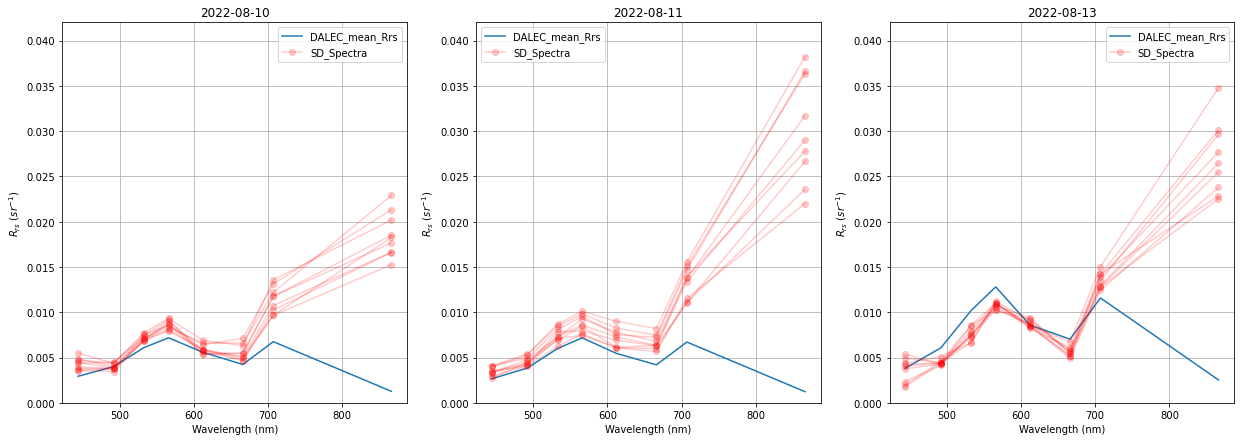

(<Figure size 1512x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'2022-08-10'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>,
        <AxesSubplot:title={'center':'2022-08-11'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>,
        <AxesSubplot:title={'center':'2022-08-13'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>],
       dtype=object))

In [9]:
SD_NC_loading.multiDaySpectraPlot(superDuperDF)

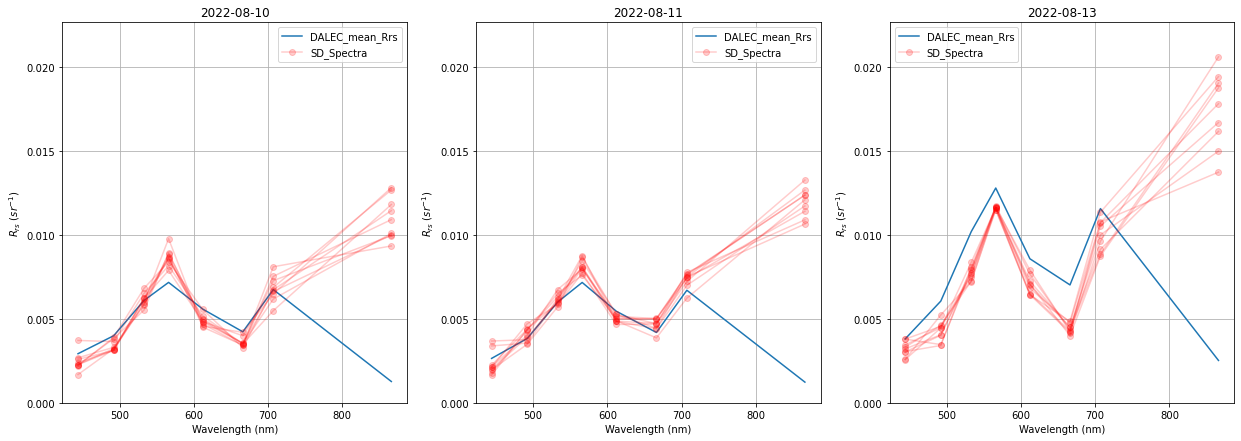

(<Figure size 1512x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'2022-08-10'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>,
        <AxesSubplot:title={'center':'2022-08-11'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>,
        <AxesSubplot:title={'center':'2022-08-13'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>],
       dtype=object))

In [10]:
# deep spectra match much better at 707 nm
multiDaySpectraPlot(superDuperDF_deep)

In [11]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

def plot_SD_DALEC_matchup(superDuperDF, DALEC_param='DALEC_mean_Rrs', SD_col_slice=slice(1, None, 1),
                          figsize=(26, 13), SD_label='SD_Spectra', grid=True, cbar=True,
                          x_y_line=True, show_plot=True):
    '''
    generates Rrs-insitu vs Rrs-SD plots for all SD wavebands with a given DF with Date, Wavelength columns 
    '''
    fig, ax = plt.subplots(2, 4, figsize=figsize)

    ax = ax.flatten()
    
    timestamps = [datetime.combine(date, datetime.min.time()).timestamp() \
                  for date in list(superDuperDF.index.get_level_values(0).unique())]    
    
    for i, wavelength in zip(range(8), superDuperDF.index.get_level_values(1).unique()):
        x = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],wavelength), :][DALEC_param].values
        #ax[i].scatter(x, y, label='DALEC Mean')
        for col in list(superDuperDF.columns.values)[SD_col_slice]:
            y = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],wavelength), :][col].values
            sc = ax[i].scatter(x, y,
                               c=timestamps,
                               cmap='jet',
                               marker='o',
                               alpha=0.5)

        ax[i].set_title('$\lambda = $' + str(wavelength) + ' nm')

        ax[i].set_xlabel('DALEC Rrs')
        ax[i].set_ylabel('SD Rrs')
        
        if cbar:
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])

            cbar = fig.colorbar(sc, cbar_ax, ticks=[min(timestamps), max(timestamps)])
            cbarTickLabels = (datetime.fromtimestamp(min(timestamps)).strftime("%d-%b"),
                              datetime.fromtimestamp(max(timestamps)).strftime("%d-%b"))
            cbar.ax.set_yticklabels(cbarTickLabels)
        

        if grid:
            ax[i].grid()

        max_xy = np.max([x, y])

        ax[i].set_ylim([0, max_xy*1.2])
        ax[i].set_xlim([0, max_xy*1.2])
        #plt.axis('equal')
        ax[i].set_aspect('equal', adjustable='box')
        #ax[i].set_aspect('equal', adjustable='datalim', anchor='C')
        if x_y_line:
            ax[i].plot([-1, 1], [-1, 1], 'k--', alpha=0.5)

    if show_plot:
        plt.show()
    return fig, ax, cbar

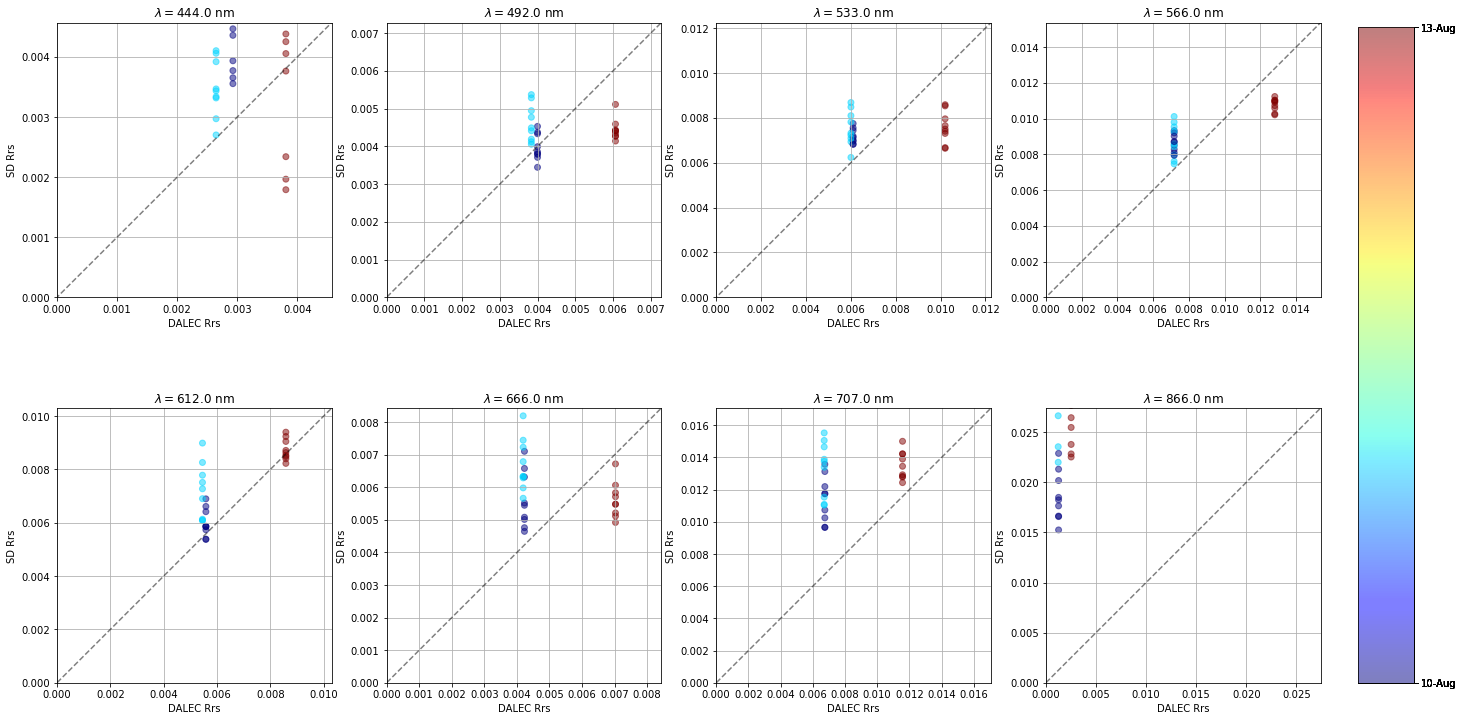

In [12]:
fig, axs, cbar = SD_NC_loading.plot_multiDay_SD_DALEC_matchup(superDuperDF)

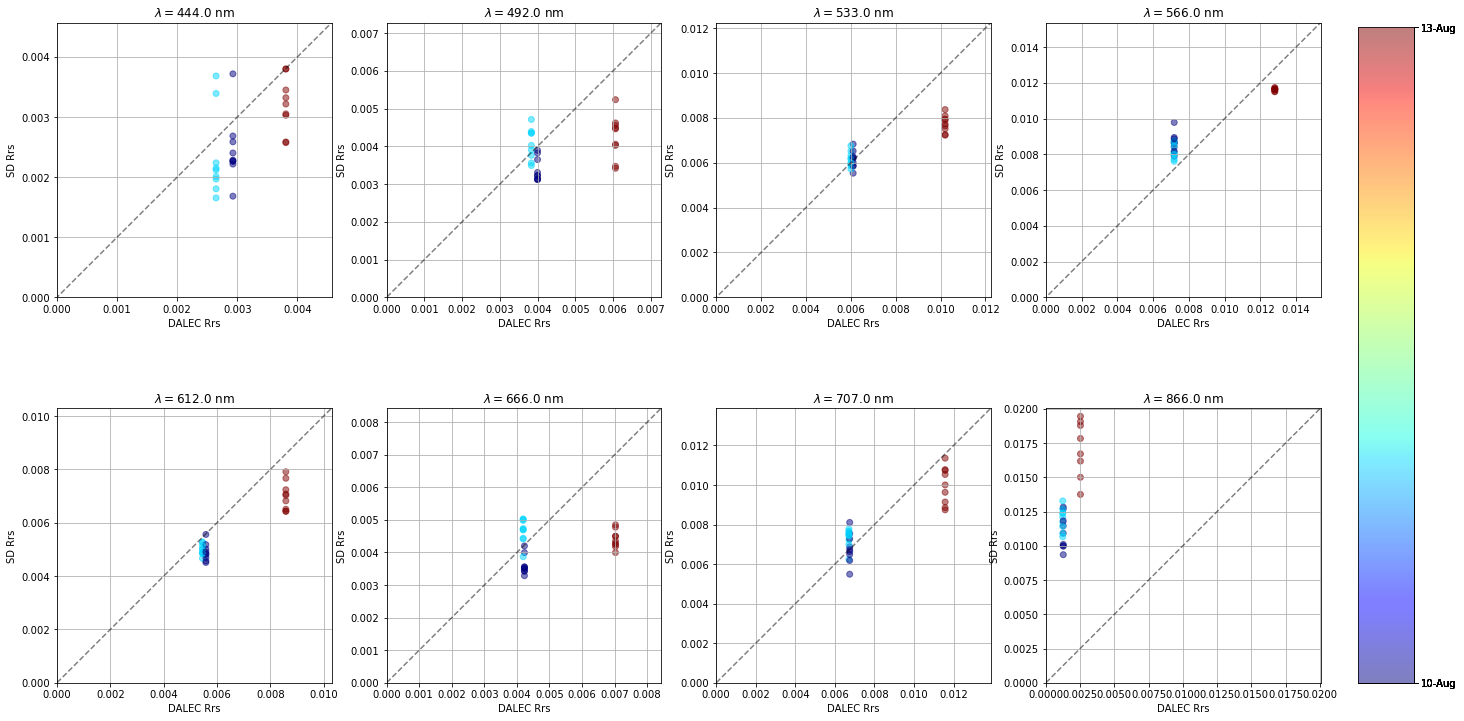

In [13]:
# to me it looks like the deep pixels match up better than the shallow ones
# probably due to adjancency effects
fig, axs, cbar = SD_NC_loading.plot_multiDay_SD_DALEC_matchup(superDuperDF_deep)

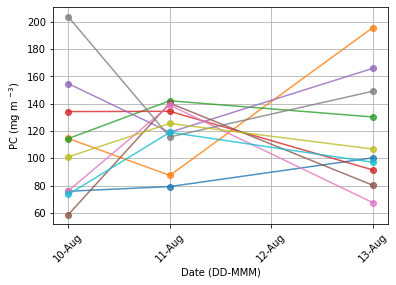

In [14]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

def NDPCI(Rrs_707, Rrs_612, alpha=46.478, beta=5.1864):
    '''
    using gomez et al 2011 NDPCI algorithm
    where PC [mg/m^3] = alpha * e ^ (beta * diff_ratio)
    and diff_ratio = (Rrs_709 - Rrs_620)/(Rrs_709 + Rrs_620)
    BUT for SD bands we use 707 and 612... should still work right?
    currently default params are those found in gomez et al 2011
    '''
    diff_ratio = (Rrs_707 - Rrs_612)/(Rrs_707 + Rrs_612)
    PC = alpha * np.exp(np.array(beta * diff_ratio, dtype=float)) # just force this to be a float array to make np.exp() happy
    return PC

def NDPCI_from_DF(df, col_name='DALEC_mean_Rrs', alpha=46.478, beta=5.1864):
    '''
    convenience function to extract Rrs_707 and Rrs_612 from a superduperdf kinda df and use this to call NDPCI()
    '''
    Rrs_612 = df.loc[(df.index.get_level_values(0)[:],612.0), :][col_name].values
    Rrs_707 = df.loc[(df.index.get_level_values(0)[:],707.0), :][col_name].values
    return NDPCI(Rrs_707, Rrs_612, alpha=alpha, beta=beta)

def plot_algorithm_from_DF(df, algorithm=NDPCI_from_DF, col_names=None, show_legend=False,
                           y_label='PC (mg m $^{-3}$)', grid=True,
                           plot_show=True, **kwargs):
    '''
    applies the chosen algorithm to the selected columns of the DF and plots the results
    if no column names are specified, then all columns will be processed and plotted
    '''
    if col_names is None:
        col_names = list(df.columns.values)
    results = [algorithm(df, col_name=col, **kwargs) for col in col_names]
    
    x = df.index.get_level_values(0).unique() # x is the list of dates
    
    for result, col_name in zip(results, col_names):
        plt.plot(x, result, label=col_name, marker='o', alpha=0.8)
        
    plt.xticks(rotation = 45)
    plt.xlabel('Date (DD-MMM)')
    plt.ylabel(y_label)

    ax = plt.gca()
    date_form = DateFormatter("%d-%b") # DD-MMM format
    ax.xaxis.set_major_formatter(date_form) # set format
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # make sure that ticks only appear daily
    if grid:
        ax.grid()
    if show_legend:
        plt.legend()
    if plot_show:
        plt.show()
        
SD_NC_loading.plot_algorithm_from_DF(superDuperDF_deep,
                                     algorithm=SD_NC_loading.NDPCI_from_DF,
                                     show_legend=False)

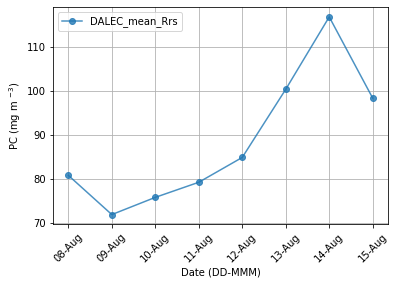

In [15]:
SD_NC_loading.plot_algorithm_from_DF(DALEC_df,
                                     algorithm=SD_NC_loading.NDPCI_from_DF,
                                     show_legend=True)

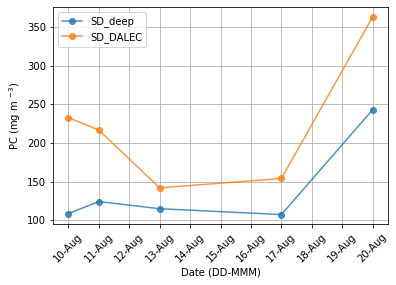

In [16]:
# looking at mean pixel values from SDs:
# this is actually some smart code! 
plot_algorithm_from_DF(pd.DataFrame(SD_df_deep_loch.mean(axis=1), columns=['SD_deep']), plot_show=False, grid=False)
plot_algorithm_from_DF(pd.DataFrame(SD_df.mean(axis=1), columns=['SD_DALEC']), show_legend=True)

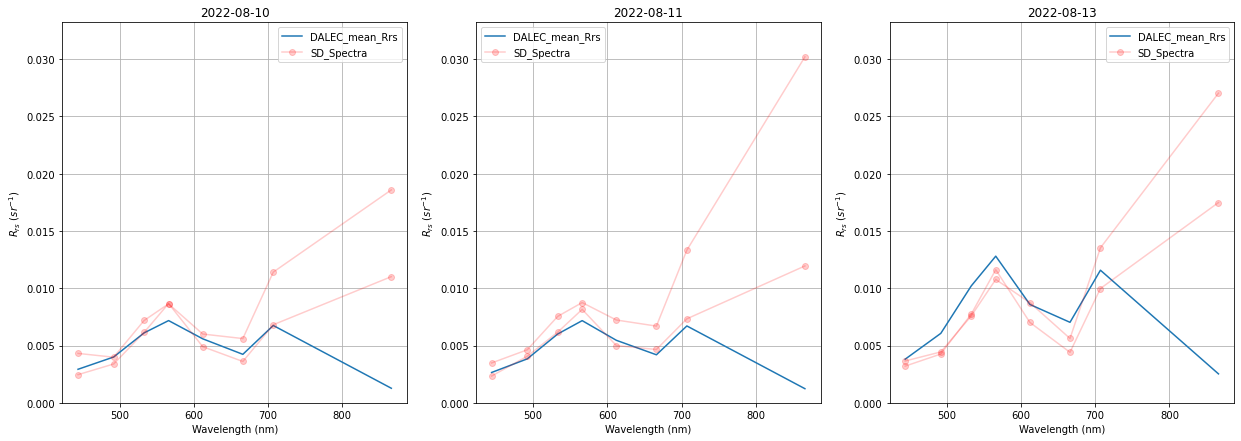

(<Figure size 1512x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'2022-08-10'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>,
        <AxesSubplot:title={'center':'2022-08-11'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>,
        <AxesSubplot:title={'center':'2022-08-13'}, xlabel='Wavelength (nm)', ylabel='$R_{rs}$ $(sr^{-1}$)'>],
       dtype=object))

In [17]:
mean_df = DALEC_df.join(pd.DataFrame(SD_df_deep_loch.mean(axis=1), columns=['SD_deep']),
                        on=['Date',
                            'Wavelength']).dropna().join(pd.DataFrame(SD_df.mean(axis=1),
                                                                      columns=['SD_DALEC']),
                                                         on=['Date', 'Wavelength'])

multiDaySpectraPlot(mean_df)

In [ ]:
fig, axs, cbar = plot_SD_DALEC_matchup(mean_df)

In [ ]:
DALEC_612 = superDuperDF_deep.loc[(superDuperDF_deep.index.get_level_values(0)[:],612.0), :]['DALEC_mean_Rrs'].values
DALEC_707 = superDuperDF_deep.loc[(superDuperDF_deep.index.get_level_values(0)[:],707.0), :]['DALEC_mean_Rrs'].values

x = superDuperDF_deep.index.get_level_values(0).unique() # x is the list of dates

DALEC_PC = NDPCI(DALEC_707, DALEC_612)

plt.plot(x, DALEC_PC)

for col in list(superDuperDF_deep.columns.values)[1:]:
    SD_612 = superDuperDF_deep.loc[(superDuperDF_deep.index.get_level_values(0)[:],612.0), :][col].values
    SD_707 = superDuperDF_deep.loc[(superDuperDF_deep.index.get_level_values(0)[:],707.0), :][col].values
    SD_PC = NDPCI(SD_707, SD_612)
    plt.plot(x, SD_PC,
               color='red',
               label='SuperDoves @ DALEC loc.',
               marker='o',
               alpha=0.2)
    
plt.xticks(rotation = 45)
plt.xlabel('Date (DD-MMM)')
plt.ylabel('PC (mg m$^{-3}$)')

ax = plt.gca()
date_form = DateFormatter("%d-%b") # DD-MMM format
ax.xaxis.set_major_formatter(date_form) # set format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # make sure that ticks only appear daily


ax.grid()
plt.show()

In [ ]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates






    

DALEC_612 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],612.0), :]['DALEC_mean_Rrs'].values
DALEC_707 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],707.0), :]['DALEC_mean_Rrs'].values



DALEC_612_707 = DALEC_707/DALEC_612

x = superDuperDF.index.get_level_values(0).unique() # x is the list of dates

plt.plot(x, DALEC_612_707)


for col in list(superDuperDF.columns.values)[1:]:
    SD_612 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],612.0), :][col].values
    SD_707 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],707.0), :][col].values

    SD_612_707 = SD_707/SD_612
    plt.plot(x, SD_612_707,
               color='red',
               label='SuperDoves @ DALEC loc.',
               marker='o',
               alpha=0.2)
    
plt.xticks(rotation = 45)
plt.xlabel('Date (DD-MMM)')
plt.ylabel('$R_{rs}[710]$ / $R_{rs}[620]$')

ax = plt.gca()
date_form = DateFormatter("%d-%b") # DD-MMM format
ax.xaxis.set_major_formatter(date_form) # set format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # make sure that ticks only appear daily
plt.show()

In [ ]:
np.exp([0.345, 0.234, 0.373737])